# Tutorial 2: Primer to Ponder

In [1]:
import ponder.bigquery
import modin.pandas as pd
import json; import os; os.chdir("..")
creds = json.load(open(os.path.expanduser("credential.json")))
bigquery_con = ponder.bigquery.connect(creds, schema = "TEST")
ponder.bigquery.init(bigquery_con)

## What is Ponder?

Ponder lets you run your pandas code directly in your data warehouse. This means that you can continue to write pandas, but with the scalability and security benefits of a modern data warehouse. 

### Key Features

- **Data science at all scales**: With Ponder's technology, the same pandas workflows can be run at all scales, from megabytes to terabytes, without changing a single line of code. 

- **No change to user workflow:** Data scientists can continue running their existing pandas workflows and writing pandas code in their favorite IDE of choice, and benefit from seamless scalability improvements.

- **Simplify your data infrastructure:** No need to set up and maintain compute infrastructure required for other parallel processing frameworks (e.g., Spark, Ray, Dask, etc.) to perform large scale data analysis with pandas.

- **Guaranteed security:** All your pandas workflows will be executed in BigQuery, thus benefiting from the rigorous security guarantees offered by BigQuery.

In the following sections, we will showcase some examples of how Ponder works and how it can be used in your work.

### Demo 1: Write SQL no more, Ponder in action!

Under the hood, pandas operations are automatically compiled down to SQL queries that get pushed to BigQuery. Queries are executed directly on BigQuery, with users benefiting from the performance, scalability, and security benefits provided by BigQuery as the computation engine.  

Here is an architecture of how Ponder works: 

<img src="https://ponder.io/wp-content/uploads/2023/01/Group-362.png" width="75%"></img>


To show you that this is actually running in the data warehouse, you can log onto your [BigQuery web interface](https://console.cloud.google.com/bigquery). The pandas operations you execute on Ponder correspond to the SQL queries shown on the `Project History` page in BigQuery web interface.

In [2]:
df = pd.read_sql("PONDER_BOOKS", bigquery_con)

You can look at the corresponding SQL queries for the pandas operations ran in Ponder by going to `Project History` in your BigQuery web interface. The history page lets you view and drill into the details of queries executed in your BigQuery account in the last 14 days.

<img src="img/bigquery_history.png" width="150%"></img>

In this case, you can see that as we connected to the table via `pd.read_sql`, this corresponding SQL query was generated: 

```sql
CREATE TEMP TABLE `Ponder_scaywlwqrc` AS SELECT *,  ROW_NUMBER() OVER (ORDER BY 1) -1  AS _PONDER_ROW_NUMBER_,  ROW_NUMBER() OVER (ORDER BY 1) -1  AS  _PONDER_ROW_LABELS_  FROM TEST.`PONDER_BOOKS`
```

You might recall that in the last tutorial, we performed z-score normalization on all the numerical columns. (We drop `O_SHIPPRIORITY` since all values are 0.)

In [3]:
x = df.drop(columns="O_SHIPPRIORITY").select_dtypes(include='number').columns
(df[x] - df[x].mean())/df[x].std()

,O_ORDERKEY,O_CUSTKEY,O_TOTALPRICE
0,0.572949,-0.228796,-0.219499
1,0.988875,-0.496957,2.070435
2,-1.077758,-0.956663,-1.401348
3,-1.292708,-0.152178,-1.309820
4,0.498456,-1.263133,0.583778
...,...,...,...
140,0.643352,0.537380,-0.548078
141,0.652724,1.801569,1.115252
142,-1.145427,-0.037252,-0.604602
143,0.008193,1.380173,2.136327


Now take a look at BigQuery's `Project History`, the corresponding SQL query is 150+ lines long!!

```sql
SELECT 
  _PONDER_ROW_LABELS_, 
  O_ORDERKEY, 
  O_CUSTKEY, 
  O_TOTALPRICE 
FROM 
  (
    SELECT 
      * 
    FROM 
      (
        SELECT 
          _PONDER_ROW_NUMBER_, 
          _PONDER_ROW_LABELS_, 
          O_ORDERKEY / O_ORDERKEY_ponder_right AS O_ORDERKEY, 
          O_CUSTKEY / O_CUSTKEY_ponder_right AS O_CUSTKEY, 
          O_TOTALPRICE / O_TOTALPRICE_ponder_right AS O_TOTALPRICE 
        FROM 
          (
            SELECT 
              _PONDER_ROW_NUMBER_, 
              _PONDER_ROW_LABELS_, 
              O_ORDERKEY - O_ORDERKEY_ponder_right AS O_ORDERKEY, 
              O_CUSTKEY - O_CUSTKEY_ponder_right AS O_CUSTKEY, 
              O_TOTALPRICE - O_TOTALPRICE_ponder_right AS O_TOTALPRICE 
            FROM 
              (
                SELECT 
                  _PONDER_ROW_NUMBER_, 
                  _PONDER_ROW_LABELS_, 
                  O_ORDERKEY, 
                  O_CUSTKEY, 
                  O_TOTALPRICE 
                FROM 
                  (
                    SELECT 
                      O_ORDERKEY, 
                      O_CUSTKEY, 
                      O_ORDERSTATUS, 
                      O_TOTALPRICE, 
                      O_ORDERDATE, 
                      O_ORDERPRIORITY, 
                      O_CLERK, 
                      O_SHIPPRIORITY, 
                      O_COMMENT, 
                      _PONDER_ROW_NUMBER_, 
                      _PONDER_ROW_LABELS_ 
                    FROM 
                      Ponder_scaywlwqrc 
                    ORDER BY 
                      _PONDER_ROW_NUMBER_
                  )
              ) AS _PONDER_LEFT_ CROSS 
              JOIN (
                SELECT 
                  O_ORDERKEY AS O_ORDERKEY_ponder_right, 
                  O_CUSTKEY AS O_CUSTKEY_ponder_right, 
                  O_TOTALPRICE AS O_TOTALPRICE_ponder_right 
                FROM 
                  (
                    SELECT 
                      0 AS _PONDER_ROW_NUMBER_, 
                      0 AS _PONDER_ROW_LABELS_, 
                      AVG(O_ORDERKEY) AS O_ORDERKEY, 
                      AVG(O_CUSTKEY) AS O_CUSTKEY, 
                      AVG(O_TOTALPRICE) AS O_TOTALPRICE 
                    FROM 
                      (
                        SELECT 
                          CAST(O_ORDERKEY AS FLOAT64) AS O_ORDERKEY, 
                          CAST(O_CUSTKEY AS FLOAT64) AS O_CUSTKEY, 
                          CAST(O_TOTALPRICE AS FLOAT64) AS O_TOTALPRICE, 
                          _PONDER_ROW_LABELS_, 
                          _PONDER_ROW_NUMBER_ 
                        FROM 
                          (
                            SELECT 
                              _PONDER_ROW_NUMBER_, 
                              _PONDER_ROW_LABELS_, 
                              O_ORDERKEY, 
                              O_CUSTKEY, 
                              O_TOTALPRICE 
                            FROM 
                              (
                                SELECT 
                                  O_ORDERKEY, 
                                  O_CUSTKEY, 
                                  O_ORDERSTATUS, 
                                  O_TOTALPRICE, 
                                  O_ORDERDATE, 
                                  O_ORDERPRIORITY, 
                                  O_CLERK, 
                                  O_SHIPPRIORITY, 
                                  O_COMMENT, 
                                  _PONDER_ROW_NUMBER_, 
                                  _PONDER_ROW_LABELS_ 
                                FROM 
                                  Ponder_scaywlwqrc 
                                ORDER BY 
                                  _PONDER_ROW_NUMBER_
                              )
                          )
                      ) 
                    LIMIT 
                      1
                  )
              ) AS _PONDER_RIGHT_
          ) AS _PONDER_LEFT_ CROSS 
          JOIN (
            SELECT 
              O_ORDERKEY AS O_ORDERKEY_ponder_right, 
              O_CUSTKEY AS O_CUSTKEY_ponder_right, 
              O_TOTALPRICE AS O_TOTALPRICE_ponder_right 
            FROM 
              (
                SELECT 
                  0 AS _PONDER_ROW_NUMBER_, 
                  0 AS _PONDER_ROW_LABELS_, 
                  STDDEV(O_ORDERKEY) AS O_ORDERKEY, 
                  STDDEV(O_CUSTKEY) AS O_CUSTKEY, 
                  STDDEV(O_TOTALPRICE) AS O_TOTALPRICE 
                FROM 
                  (
                    SELECT 
                      _PONDER_ROW_NUMBER_, 
                      _PONDER_ROW_LABELS_, 
                      O_ORDERKEY, 
                      O_CUSTKEY, 
                      O_TOTALPRICE 
                    FROM 
                      (
                        SELECT 
                          O_ORDERKEY, 
                          O_CUSTKEY, 
                          O_ORDERSTATUS, 
                          O_TOTALPRICE, 
                          O_ORDERDATE, 
                          O_ORDERPRIORITY, 
                          O_CLERK, 
                          O_SHIPPRIORITY, 
                          O_COMMENT, 
                          _PONDER_ROW_NUMBER_, 
                          _PONDER_ROW_LABELS_ 
                        FROM 
                          Ponder_scaywlwqrc 
                        ORDER BY 
                          _PONDER_ROW_NUMBER_
                      )
                  ) 
                LIMIT 
                  1
              )
          ) AS _PONDER_RIGHT_
      ) 
    WHERE 
      _PONDER_ROW_NUMBER_ IN (
        0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 
        14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 
        24, 25, 26, 27, 28, 29, 30, 114, 115, 116, 
        117, 118, 119, 120, 121, 122, 123, 124, 
        125, 126, 127, 128, 129, 130, 131, 132, 
        133, 134, 135, 136, 137, 138, 139, 140, 
        141, 142, 143, 144
      )
  ) 
ORDER BY 
  _PONDER_ROW_NUMBER_ 
LIMIT 
  10001
```

In this example, we saw how something as easy to express in pandas in a single line can in fact take *many* lines of SQL to write. 

Using Ponder leads to huge time-savings since you can think and work natively in pandas when interacting with your data warehouse.

### Demo 2: Scaling Ponder on big data

Ponder is built on our open-source project, [Modin](https://modin.readthedocs.io/en/latest/), which is a faster, more scalable version of pandas. Modin has more than 5M+ downloads to-date and is being adopted in leading data and AI teams. We built Modin and Ponder to address the scalability bottlenecks that practitioners face when using pandas (which is single-threaded and often leads to out-of-memory errors). But unlike other big data frameworks (e.g., Spark, SQL), we let you continue using the same pandas API and semantics, while doing the magic behind the scenes to let you scale on hundreds of GB up to terabytes of data.

In [4]:
import time

In this demo, we perform a series of operations with Ponder and Pandas to compare the performance of working with large datasets. 

First, we load in the CSV file which contains the NYC taxi dataset. The size of this CSV file is 22.6MB.

In [5]:
df = pd.read_csv("https://github.com/ponder-org/ponder-datasets/blob/main/yellow_tripdata_2015-01.csv?raw=True", on_bad_lines='skip')

Creating table in BigQuery...
Finished creating table in BigQuery...
Finished loading data into BigQuery.
Dataframe loading complete.


In [6]:
start  = time.time()
bigdf = pd.concat([df for _ in range(100)])
end = time.time()
ponder_concat_duration = end - start

In [7]:
print("Time for concat with Ponder: {} seconds".format(round(ponder_concat_duration, 2)))

Time for concat with Ponder: 1.14 seconds


In [8]:
start  = time.time()
display(bigdf.groupby("PASSENGER_COUNT").mean())
end = time.time()
ponder_groupby_duration = end - start

,VENDORID,TRIP_DISTANCE,RATECODEID,PULOCATIONID,DOLOCATIONID,PAYMENT_TYPE,FARE_AMOUNT,EXTRA,MTA_TAX,TIP_AMOUNT,TOLLS_AMOUNT,IMPROVEMENT_SURCHARGE,TOTAL_AMOUNT
PASSENGER_COUNT,,,,,,,,,,,,,
0,1.130435,2.141739,9.043478,165.130435,154.217391,1.652174,17.150435,0.250000,0.304348,0.948043,0.423913,0.039130,19.357174
1,1.506007,3.289600,1.045137,155.058457,151.812726,1.510181,12.861238,0.269200,0.496114,1.329329,0.202550,0.150203,15.455671
2,1.466004,3.608892,1.066553,155.405790,152.076833,1.496764,13.963329,0.289076,0.494514,1.443935,0.319719,0.138124,16.807681
3,1.491227,3.568215,1.061660,153.808708,151.956543,1.538291,13.929069,0.304526,0.493727,1.324659,0.302686,0.146261,16.652097
4,1.393275,3.652979,1.101025,153.760427,151.656227,1.603839,14.444529,0.288786,0.492062,1.177842,0.378460,0.116380,17.078130
5,1.989759,3.456300,1.023275,153.885231,150.142192,1.497080,13.201483,0.288320,0.497757,1.330433,0.248330,0.292383,15.861550
6,1.998547,3.384467,1.021260,152.325763,150.321933,1.495180,12.905982,0.254259,0.498812,1.305881,0.212104,0.297148,15.474779


In [9]:
print("Time for groupby.mean with Ponder: {} seconds".format(round(ponder_groupby_duration, 2)))

Time for groupby.mean with Ponder: 12.47 seconds


In [10]:
import pandas as old_pd

In [11]:
pandas_df = old_pd.read_csv("https://github.com/ponder-org/ponder-datasets/blob/main/yellow_tripdata_2015-01.csv?raw=True", on_bad_lines='skip')

In [12]:
start  = time.time()
pandas_bigdf = old_pd.concat([pandas_df for _ in range(100)])
end = time.time()
pandas_concat_duration = end - start

In [13]:
print("Time for concat with pandas: {} seconds".format(round(pandas_concat_duration, 2)))

Time for concat with pandas: 2.09 seconds


In [14]:
start  = time.time()
display(pandas_bigdf.groupby("PASSENGER_COUNT").mean())
end = time.time()
pandas_groupby_duration = end - start

,VENDORID,TRIP_DISTANCE,RATECODEID,PULOCATIONID,DOLOCATIONID,PAYMENT_TYPE,FARE_AMOUNT,EXTRA,MTA_TAX,TIP_AMOUNT,TOLLS_AMOUNT,IMPROVEMENT_SURCHARGE,TOTAL_AMOUNT
PASSENGER_COUNT,,,,,,,,,,,,,
0,1.130435,2.141739,9.043478,165.130435,154.217391,1.652174,17.150435,0.250000,0.304348,0.948043,0.423913,0.039130,19.357174
1,1.506007,3.289600,1.045137,155.058457,151.812726,1.510181,12.861238,0.269200,0.496114,1.329329,0.202550,0.150203,15.455671
2,1.466004,3.608892,1.066553,155.405790,152.076833,1.496764,13.963329,0.289076,0.494514,1.443935,0.319719,0.138124,16.807681
3,1.491227,3.568215,1.061660,153.808708,151.956543,1.538291,13.929069,0.304526,0.493727,1.324659,0.302686,0.146261,16.652097
4,1.393275,3.652979,1.101025,153.760427,151.656227,1.603839,14.444529,0.288786,0.492062,1.177842,0.378460,0.116380,17.078130
5,1.989759,3.456300,1.023275,153.885231,150.142192,1.497080,13.201483,0.288320,0.497757,1.330433,0.248330,0.292383,15.861550
6,1.998547,3.384467,1.021260,152.325763,150.321933,1.495180,12.905982,0.254259,0.498812,1.305881,0.212104,0.297148,15.474779


In [15]:
print("Time for groupby.mean with pandas: {} seconds".format(round(pandas_groupby_duration, 2)))

Time for groupby.mean with pandas: 2.1 seconds


In [16]:
# Install matplotlib if you don't already have it
! pip install matplotlib --quiet

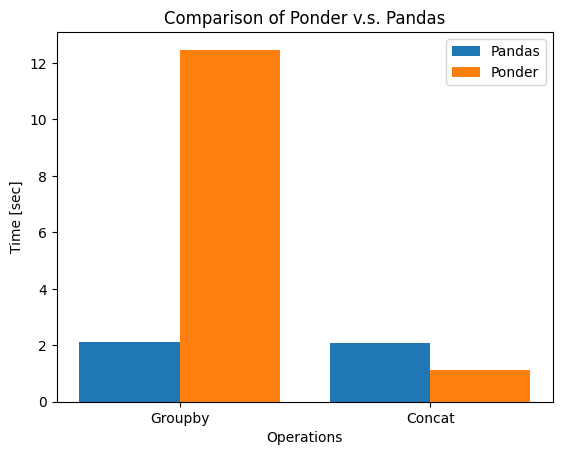

In [17]:
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['Groupby','Concat']
t_pandas = [pandas_groupby_duration,pandas_concat_duration]
t_ponder = [ponder_groupby_duration,ponder_concat_duration]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, t_pandas, 0.4, label = 'Pandas')
plt.bar(X_axis + 0.2, t_ponder, 0.4, label = 'Ponder')
  
plt.xticks(X_axis, X)
plt.xlabel("Operations")
plt.ylabel("Time [sec]")
plt.title("Comparison of Ponder v.s. Pandas")
plt.legend()
plt.show()

### Summary

In this tutorial, we saw how Ponder lets you run pandas on BigQuery. 

Demo #1 showed how Ponder simplifies your experience in working with data. It does this by translating your pandas queries to corresponding SQL queries to run on your data warehouse. Ponder gives you the flexibility of working in pandas directly and often there are queries that are easier to write in pandas than having to craft hundreds of lines of SQL!

Demo #2 showed the scale benefits you get from using Ponder in working with large datasets. We saw that Ponder leverages the inherent parallelism of the data warehouse to speed up your pandas queries, leading to runtimes that are much faster than vanilla pandas.

As we can see, there are many benefits from being able to leverage the pandas API (over writing SQL directly) on your data warehouse, as summarized in this table. 

|               | pandas | SQL | Ponder |
|---------------|--------|-----|--------|
| Easy to use   | ✅      | ❌   | ✅      |
| Flexible      | ✅      | ❌   | ✅      |
| Scalable      | ❌      | ✅   | ✅      |
| Secure access | ❌      | ✅   | ✅      |


To learn more about Ponder, check out our product blogpost [here](https://ponder.io/run-pandas-on-1tb-directly-in-your-data-warehouse/).